In [1]:
import numpy as np 
import pandas as pd 
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Headers required for stats.nba.com
HEADERS = {
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://www.nba.com/',
    'Origin': 'https://www.nba.com',
    'Connection': 'keep-alive',
}

In [2]:
class Team:
    def __init__(self, name, wins, games_played=41):
        self.name = name
        self.wins = wins
        self.games_played = games_played
        self.n = wins / games_played
        self.a1, self.b1, self.c1, self.d1, self.a2, self.b2, self.c2, self.d2 = generate_ordered_constants(self.n)

    def payoff_matrix(self):
        """
        Returns two 2×2 arrays: (playoff_matrix, draft_matrix) according to GT equation
        """
        playoff_matrix = np.array([[self.a1, self.b1],
                                   [self.c1, self.d1]])
        draft_matrix   = np.array([[self.a2, self.b2],
                                   [self.c2, self.d2]])
        return playoff_matrix, draft_matrix

    def describe_matrix(self):
        """
        Creates  the expected payoff matrix 
          M_exp = n·M_playoff + (1−n)·M_draft,
        and then sums all entries to one float.
        """
        M_playoff, M_draft = self.payoff_matrix()
        M_exp = self.n * M_playoff + (1 - self.n) * M_draft
        scalar_payoff = M_exp.sum()  # sum over all four entries
        return scalar_payoff

    def __repr__(self):
        return f"Team(name={self.name!r}, wins={self.wins}, games_played={self.games_played})"

    def __str__(self):
        scalar = self.describe_matrix()
        return (
            f"Team: {self.name}\n"
            f"  Win‐Rate (n)        = {self.n:.3f}\n"
            f"  Scalar Payoff = {scalar:.3f}"
        )


In [3]:
def tank_GT(team: Team):
    n = team.n
    playoff_matrix, draft_matrix = team.payoff_matrix()

    # Expected payoff matrix as weighted average where each scalar is applied to its matrix and the results are summed 
    expected_matrix = n * playoff_matrix + (1 - n) * draft_matrix
    return expected_matrix


In [4]:
def generate_ordered_constants(n):
    """
    Generate (a1,b1,c1,d1,a2,b2,c2,d2) based on current win-rate n ∈ [0,1].
    Here:
      - a2,b2,c2,d2 are 'draft-centric' payoffs ∝ (1 − n).
      - a1,b1,c1,d1 are 'playoff-centric' payoffs ∝ n, offset by small random noise.
    """
    # 1) Draft matrix constants scale with (1 − n):
    #    bigger (1-n) ⇒ bigger draft payoffs (stronger incentive to tank).
    a2 = (1 - n) * 10 + np.random.uniform(0, 1)   # best draft reward if tanking
    b2 = (1 - n) * 8  + np.random.uniform(0, 1)   # middle reward
    c2 = (1 - n) * 5  + np.random.uniform(0, 1)
    d2 = (1 - n) * 2  + np.random.uniform(0, 1)

    # 2) Playoff matrix constants scale with n:
    #    bigger n ⇒ bigger playoff rewards (stronger incentive to compete).
    #    We ensure “playoff” entries are generally larger than “draft” entries 
    #    for positive n. You can adjust these offsets to match your paper’s intuition.
    a1 = a2 + np.random.uniform(1, 2)       # prefer winning playoffs even if other tanks
    b1 = b2 - np.random.uniform(1, 2)       # low‐seed playoff vs. decent draft pick
    c1 = c2 + np.random.uniform(1, 2)       # winning when others tank ⇒ strong
    d1 = c1 + np.random.uniform(1, 2)       # both teams “good” ⇒ best outcome
    
    assert a1 > a2 and b1 < b2 and c1 > c2 and d1 > d2 and c1 < d1
    
    return a1, b1, c1, d1, a2, b2, c2, d2


In [5]:
for wins, gp in [(5, 20), (10, 20), (15, 20), (20, 20)]:
    t = Team("Testers", wins=wins, games_played=gp)
    print(f" Wins={wins}/{gp} (n={t.n:.3f})  →  Scalar Payoff = {t.describe_matrix():.3f}")


 Wins=5/20 (n=0.250)  →  Scalar Payoff = 22.046
 Wins=10/20 (n=0.500)  →  Scalar Payoff = 16.845
 Wins=15/20 (n=0.750)  →  Scalar Payoff = 13.066
 Wins=20/20 (n=1.000)  →  Scalar Payoff = 5.908


In [6]:
def get_team_game_log(team_id, season):
    """
    Fetch a team's regular‐season game log from stats.nba.com for "season" 
    (e.g. '2023-24'). Returns a DataFrame sorted by date with columns:
      [GAME_DATE, WL, CUM_WINS, GAMES_PLAYED, …]
    """
    url = 'https://stats.nba.com/stats/teamgamelog'
    params = {
        'TeamID': team_id,
        'Season': season,
        'SeasonType': 'Regular Season'
    }
    resp = requests.get(url, headers=HEADERS, params=params)
    resp.raise_for_status()
    
    data = resp.json()['resultSets'][0]
    columns = data['headers']
    rows = data['rowSet']
    
    df = pd.DataFrame(rows, columns=columns)
    
    # Explicitly infer the ISO‐8601 format so pandas doesn't warn
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], format="%b %d, %Y")
    df = df.sort_values('GAME_DATE').reset_index(drop=True)
    
    # Compute cumulative wins
    wins = 0
    cum_wins = []
    for idx, row in df.iterrows():
        if row['WL'] == 'W':
            wins += 1
        cum_wins.append(wins)
    
    df['CUM_WINS'] = cum_wins
    df['GAMES_PLAYED'] = df.index + 1
    return df


In [7]:
# Fetch the list of all teams (team IDs & names) from stats.nba.com
seasons = ['2023-24']
ref_season = seasons[0]

standings_url = 'https://stats.nba.com/stats/leaguestandingsv3'
params = {
    'LeagueID': '00',
    'Season': ref_season,
    'SeasonType': 'Regular Season'
}

resp = requests.get(standings_url, headers=HEADERS, params=params)
resp.raise_for_status()

data = resp.json()['resultSets'][0]
columns = data['headers']
rows = data['rowSet']

df_standings = pd.DataFrame(rows, columns=columns)
teams_info = [
    (int(row['TeamID']), row['TeamName'])
    for _, row in df_standings.iterrows()
]


In [8]:
import time
from requests.exceptions import HTTPError, Timeout

team_logs = {}
missing = []  # to record any (season, team_id) that fail permanently (see below)

# I was having some HTTP issues previously so I added some debugging and waiting just in case the API was slow or had weird limits
# It works now but I kept the debugging in 
DELAY_BETWEEN_REQUESTS = 0.2
MAX_RETRIES_429 = 3

for season in seasons:
    for team_id, team_name in teams_info:
        key = (season, team_id)
        attempt = 0

        while True: 
            attempt += 1
            try:
                #Fetch the game log with a 10‐second timeout
                df_log = get_team_game_log(team_id, season)
                team_logs[key] = (team_name, df_log)
                break   # success → exit retry‐loop

            except HTTPError as http_err:
                status = http_err.response.status_code
                print(f"HTTP error for {team_name} ({team_id}) in {season}: {http_err}")
                missing.append(key)
                break

            except Timeout:
                # Request timed out (I sometimes had API call issues that would not 
                # show up in the kernel so I have this to handle those errors)
                print(f"Timeout fetching {team_name} ({team_id}) for {season} on attempt {attempt}")
                missing.append(key)
                break

            except Exception as e:
                print(f"Error fetching {team_name} ({team_id}) for {season}: {e}")
                missing.append(key)
                break

        time.sleep(DELAY_BETWEEN_REQUESTS)

print(f"\nFinished building team_logs.  Successful entries: {len(team_logs)}")
if missing:
    print(f"Failed to fetch {len(missing)} team‐season pairs. Sample: {missing[:5]}")



Finished building team_logs.  Successful entries: 30


In [9]:
payoff_results = {}

for season in seasons:
    payoff_results[season] = {}
    season_team_ids = [tid for (s, tid) in team_logs.keys() if s == season]

    for team_id in season_team_ids:
        team_name, df_team = team_logs[(season, team_id)]
        inner_products = []

        for idx, row in df_team.iterrows():
            wins = row['CUM_WINS']
            gp = row['GAMES_PLAYED']
            team_obj = Team(team_name, wins=wins, games_played=gp)
            pm, dm = team_obj.payoff_matrix()
            M_team = team_obj.n * pm + (1 - team_obj.n) * dm

            ip_dict = {}
            for opp_id in season_team_ids:
                if opp_id == team_id:
                    continue
                opp_name, df_opp = team_logs[(season, opp_id)]
                if len(df_opp) > idx:
                    opp_wins = df_opp.loc[idx, 'CUM_WINS']
                    opp_gp = df_opp.loc[idx, 'GAMES_PLAYED']
                    opp_obj = Team(opp_name, wins=opp_wins, games_played=opp_gp)
                    pm_opp, dm_opp = opp_obj.payoff_matrix()
                    M_opp = opp_obj.n * pm_opp + (1 - opp_obj.n) * dm_opp

                    ip = np.sum(M_team * M_opp)
                    ip_dict[opp_id] = ip

            inner_products.append(ip_dict)

        payoff_results[season][team_id] = inner_products


In [10]:
def normalize_series(df):
    """
    Perform min–max normalization on each column of df so that
    values lie between 0 and 1. Returns a new DataFrame.
    """
    # Compute column‐wise min and max
    col_min = df.min()
    col_max = df.max()
    # Avoid division by zero: if max == min, result will be all zeros
    denom = (col_max - col_min).replace(0, 1)
    return (df - col_min) / denom

# Example: pick one team/season to normalize
season = '2023-24'
team_id = teams_info[0][0]  # e.g., first team in teams_info
inner_list = payoff_results[season][team_id]
df_ip = pd.DataFrame(inner_list).fillna(0)

# Normalize each opponent‐column separately
df_ip_norm = normalize_series(df_ip)

# Inspect the first few rows to confirm scaling
df_ip_norm.head(5)


,1610612760,1610612743,1610612752,1610612749,1610612750,1610612739,1610612746,1610612742,1610612753,1610612754,...,1610612745,1610612751,1610612762,1610612761,1610612763,1610612766,1610612759,1610612764,1610612765,1610612757
0,0.021506,0.107225,0.082386,0.000000,0.104337,0.000000,0.000000,0.100773,0.113109,0.000000,...,0.000000,0.120922,0.129945,0.000000,0.000000,0.000000,0.000000,0.015212,0.134097,0.074593
1,0.219524,0.293339,0.221457,0.381301,0.466073,0.282580,0.304102,0.217217,0.032488,0.284121,...,0.256493,0.228530,0.166914,0.213832,0.158182,0.217649,0.139200,0.107990,0.203627,0.229925
2,0.343834,0.045914,0.230035,0.290465,0.289591,0.196191,0.047801,0.136952,0.199119,0.173201,...,0.250891,0.210332,0.164221,0.292004,0.111777,0.186764,0.110796,0.079538,0.060585,0.197576
3,0.000000,0.000000,0.000000,0.135402,0.000000,0.094513,0.091852,0.000000,0.000000,0.012981,...,0.043893,0.000000,0.000000,0.115141,0.014595,0.054766,0.011576,0.000000,0.000000,0.000000
4,0.619200,0.336739,0.339451,0.547628,0.301708,0.309331,0.302844,0.356765,0.285039,0.410302,...,0.357058,0.359457,0.297179,0.385262,0.338754,0.240752,0.150003,0.262815,0.243588,0.274737


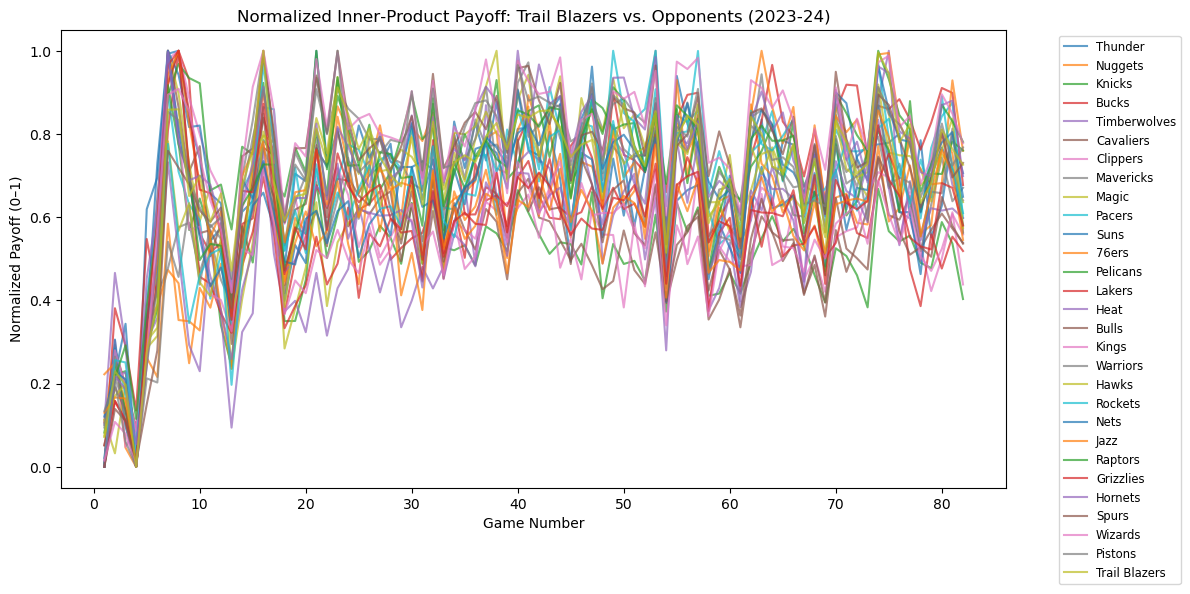

In [11]:
plt.figure(figsize=(12, 6))
for opp_id in df_ip_norm.columns:
    opp_name = next(name for tid, name in teams_info if tid == opp_id)
    plt.plot(df_ip_norm.index + 1, df_ip_norm[opp_id], label=opp_name, alpha=0.7)

plt.title(f'Normalized Inner‐Product Payoff: {team_name} vs. Opponents ({season})')
plt.xlabel('Game Number')
plt.ylabel('Normalized Payoff (0–1)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

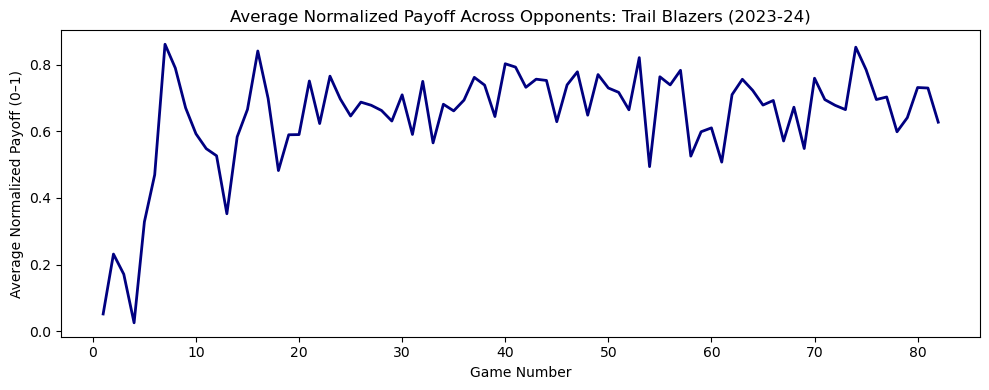

In [12]:
# Compute the row‐wise mean of the normalized DataFrame
avg_payoff = df_ip_norm.mean(axis=1)

plt.figure(figsize=(10, 4))
plt.plot(avg_payoff.index + 1, avg_payoff, color='navy', linewidth=2)
plt.title(f'Average Normalized Payoff Across Opponents: {team_name} ({season})')
plt.xlabel('Game Number')
plt.ylabel('Average Normalized Payoff (0–1)')
plt.tight_layout()
plt.show()


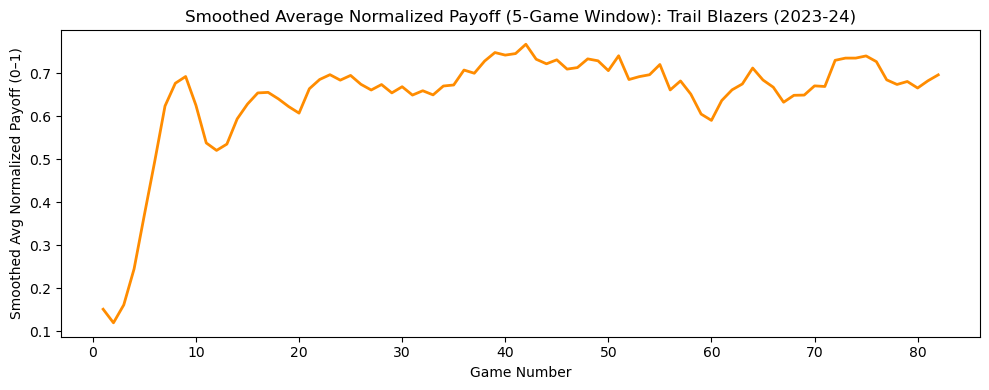

In [13]:
# ─── Cell K (optional): Smooth the average trend using a rolling window ───────────────────────────────
# Apply a rolling mean to reduce volatility (e.g., window of 5 games)
avg_smoothed = avg_payoff.rolling(window=5, min_periods=1, center=True).mean()

plt.figure(figsize=(10, 4))
plt.plot(avg_smoothed.index + 1, avg_smoothed, color='darkorange', linewidth=2)
plt.title(f'Smoothed Average Normalized Payoff (5‐Game Window): {team_name} ({season})')
plt.xlabel('Game Number')
plt.ylabel('Smoothed Avg Normalized Payoff (0–1)')
plt.tight_layout()
plt.show()
